# Example of using the orm classes

Imports

In [1]:
from core.core import Project
from core.orm import BoreholeOrm, Base
from striplog import Lexicon, Striplog, Interval, Component, Position, Decor, Legend
from striplog.utils import hex_to_rgb
from matplotlib.colors import ListedColormap
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import omfvista as ov
import pyvista as pv
import omf

In [3]:
! rm ./tmp/test_orm_db.db

In [4]:
def striplog_legend_to_omf_legend(legend):
    omf_legend=[]
    newcolors = [np.array([0.9, 0.9, 0.9, 1.])]
    for i in legend:
        omf_legend.append(i.colour)
        newcolors.append(np.hstack([np.array(hex_to_rgb(i.colour))/255, np.array([1.])]))
    return omf.data.Legend(description='', name='', values=omf.data.ColorArray(omf_legend)), ListedColormap(newcolors)

In [5]:
components = [Component({'lithology': 'siltstone', 'colour': 'grey'}),
              Component({'lithology': 'anhydrite'}),
              Component({'lithology': 'sandstone', 'grainsize': 'vf-f', 'colour': 'grey'}),
              Component({'lithology': 'dolomite'}),
              Component({'lithology': 'siltstone', 'colour': 'red'}),
              Component({'lithology': 'limestone'})]
list_of_decors=[]
hatches = ['=', 'x', '.', 's', '=', 'b']
colours = ['#888888', '#882222', '#AAAAAA', '#CC22CC', '#CC2222', '#2222CC']
for i in range(len(components)):
    d = {'color': colours[i],
         'hatch': hatches[i],
         'component': components[i],
         'width': 3}
    decor = Decor(d)
    list_of_decors.append(decor)
legend = Legend(list_of_decors)

In [6]:
omf_legend, omf_cmap = striplog_legend_to_omf_legend(legend)

Define the project class

In [7]:
class Borehole3D(Striplog):
    #-------------------------------Docstring--------------------------------------------
    """
        
    """
    
    #------------------------------ Properties -------------------------------------------
    def __init__ (self, intervals=None, name='', legend=None, x_collar=0., y_collar=0.):
        self.name = name

        if legend is None or not isinstance(legend, Legend):
            self.legend = Legend.default()
        else:
            self.legend = legend
            
        self.x_collar = x_collar
        self.y_collar = y_collar
        self.omf_legend, self.omf_cmap = striplog_legend_to_omf_legend(self.legend)
            
        if intervals is None:
            lexicon=Lexicon.default()
            with open('../data/test.las', 'r') as las3:
                default_intv=Striplog.from_las3(las3.read(), lexicon)
                intervals = list(default_intv)
            print("Pay attention that default intervals are actually used !\n")
        self.intervals = intervals
        self.geometry = []
        
        # instanciation with supers properties
        Striplog.__init__(self, list_of_Intervals=self.intervals)
        
        #self.uid=uuid #get a unique for identification of borehole in the project

        self.build_geometry()
        
    def get_components_indices(self):
        indices = []
        for i in self.intervals:
            if i.components[0] in self.components:
                indices.append(self.components.index(i.components[0]))
            else:
                indices.append(-1)
        return np.array(indices)
    
    def build_geometry(self):
    
        vertices, segments = [], []
        
        for i in self.intervals:
            if i.top not in vertices:
                if hasattr(i.top, 'x') and hasattr(i.top, 'y'):
                    x = i.top.x
                    y = i.top.y
                else:
                    x = self.x_collar
                    y = self.y_collar
                vertices.append([x, y, -i.top.z])
                top = len(vertices)-1
            else:
                top = vertices.index(i.top)
            if i.base not in vertices:
                if hasattr(i.base, 'x') and hasattr(i.base, 'y'):
                    x = i.base.x
                    y = i.base.y
                else:
                    x = self.x_collar
                    y = self.y_collar
                vertices.append([x, y, -i.base.z])
                base = len(vertices)-1
            else:
                base = vertices.index(i.base)
                
            segments.append([top, base])
            
        vertices=np.array(vertices)

        self.geometry = omf.LineSetElement(name=self.name,
                                 geometry=omf.LineSetGeometry(
                                     vertices=vertices,
                                     segments=segments),
                                 data=[omf.MappedData(name='component',
                                                      description='test',
                                                      array=omf.ScalarArray(self.get_components_indices()),
                                                      legends=[self.omf_legend],
                                                      location='segments')]
                                          )
            
        print("Borehole geometry created successfully !")
        
        return self.geometry
        
    def plot3d(self):
        omf_legend, omf_ = striplog_legend_to_omf_legend(self.legend)
        pl = pv.Plotter()
        seg = ov.line_set_to_vtk(self.geometry)
        seg.set_active_scalars('component')
        ov.lineset.add_data(seg, self.geometry.data)
        pl.add_mesh(seg.tube(radius=3), cmap=self.omf_cmap)
        pl.show()

In [8]:
bh3d = Borehole3D(legend=legend)

Pay attention that default intervals are actually used !

Borehole geometry created successfully !


<AxesSubplot:>

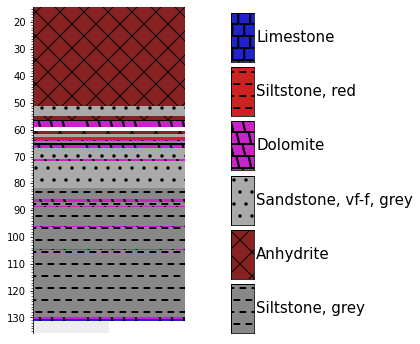

In [9]:
fix, ax = plt.subplots(ncols=2, figsize=(6,6))
bh3d.plot(legend=legend, ax=ax[0])
bh3d.legend.plot(ax=ax[1])

In [10]:
b = bh3d.intervals[0].base

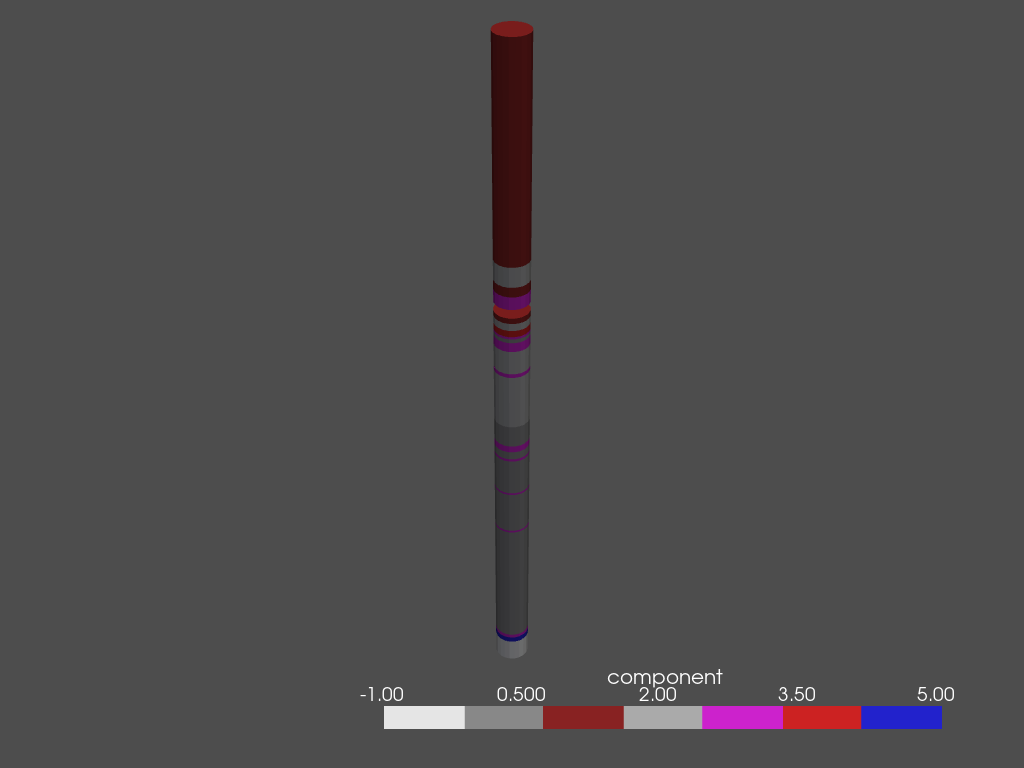

In [11]:
bh3d.plot3d()

In [12]:
project = ov.load_project('omfproj.omf')

Create the db engine and the database structure

In [14]:
engine = create_engine('sqlite:///tmp/test_orm_db.db', echo=True)

In [15]:
Base.metadata.create_all(engine)

2020-12-12 19:44:57,576 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-12-12 19:44:57,577 INFO sqlalchemy.engine.base.Engine ()
2020-12-12 19:44:57,579 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-12-12 19:44:57,580 INFO sqlalchemy.engine.base.Engine ()
2020-12-12 19:44:57,581 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Boreholes")
2020-12-12 19:44:57,583 INFO sqlalchemy.engine.base.Engine ()
2020-12-12 19:44:57,587 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Boreholes")
2020-12-12 19:44:57,588 INFO sqlalchemy.engine.base.Engine ()
2020-12-12 19:44:57,589 INFO sqlalchemy.engine.base.Engine PRAGMA main.table_info("Intervals")
2020-12-12 19:44:57,590 INFO sqlalchemy.engine.base.Engine ()
2020-12-12 19:44:57,591 INFO sqlalchemy.engine.base.Engine PRAGMA temp.table_info("Intervals")
2020-12-12 19:44:57,591 INFO sqlalchemy.engine.base.Engine ()
2020-12-12

Create the objects from las files

In [16]:
lexicon = Lexicon.default()

In [17]:
borehole_dict = {'F01':'../data/test.las', 'F02':'../data/test.las'} # boreholes to insert into the db

In [18]:
int_id = 0
bh_id = 0
boreholes = []
components = []
comp_id = 0
component_dict={}
for bh, filename in borehole_dict.items():
    interval_number = 0
    boreholes.append(BoreholeOrm(id=bh))
    with open(filename, 'r') as las3:
        strip = Striplog.from_las3(las3.read(), lexicon)
    for c in strip.components:
        if c not in component_dict.keys():
            component_dict.update({c:comp_id})
            comp_id += 1
    d ={}
    for interval in strip:
        d.update({int_id:{'description':interval.description, 'interval_number' : interval_number}})
        interval_number+=1
        int_id += 1
    boreholes[bh_id].intervals_values = d
    bh_id += 1 
components = {v:k for k,v in component_dict.items()}     

Create the session

In [19]:
Session = sessionmaker(bind=engine)
session = Session()

Create the project

In [20]:
p = Project(session)

2020-12-12 19:45:11,423 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-12 19:45:11,426 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"
2020-12-12 19:45:11,427 INFO sqlalchemy.engine.base.Engine ()


Add boreholes into the database

In [22]:
for bh in boreholes:
    p.add_borehole(bh)

2020-12-12 19:45:33,011 INFO sqlalchemy.engine.base.Engine COMMIT
2020-12-12 19:45:33,014 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-12 19:45:33,015 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"
2020-12-12 19:45:33,018 INFO sqlalchemy.engine.base.Engine ()
2020-12-12 19:45:33,020 INFO sqlalchemy.engine.base.Engine COMMIT
2020-12-12 19:45:33,021 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-12 19:45:33,023 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes"
2020-12-12 19:45:33,023 INFO sqlalchemy.engine.base.Engine ()


In [23]:
p.boreholes[0].id

'F01'

In [24]:
p.boreholes[1].id='F33'

In [25]:
p.boreholes[1].id

'F33'

In [26]:
p.commit()

2020-12-12 19:45:34,674 INFO sqlalchemy.engine.base.Engine UPDATE "Boreholes" SET id=? WHERE "Boreholes".id = ?
2020-12-12 19:45:34,676 INFO sqlalchemy.engine.base.Engine ('F33', 'F02')
2020-12-12 19:45:34,677 INFO sqlalchemy.engine.base.Engine COMMIT


In [27]:
p.boreholes[0].intervals[0].description

2020-12-12 19:45:35,236 INFO sqlalchemy.engine.base.Engine BEGIN (implicit)
2020-12-12 19:45:35,237 INFO sqlalchemy.engine.base.Engine SELECT "Boreholes".id AS "Boreholes_id" 
FROM "Boreholes" 
WHERE "Boreholes".id = ?
2020-12-12 19:45:35,238 INFO sqlalchemy.engine.base.Engine ('F01',)
2020-12-12 19:45:35,241 INFO sqlalchemy.engine.base.Engine SELECT "Intervals".id AS "Intervals_id", "Intervals".borehole AS "Intervals_borehole", "Intervals".interval_number AS "Intervals_interval_number", "Intervals".description AS "Intervals_description" 
FROM "Intervals" 
WHERE ? = "Intervals".borehole
2020-12-12 19:45:35,242 INFO sqlalchemy.engine.base.Engine ('F01',)


'Anhydrite'

In [ ]:
session.close()

### Test linking orm and omf : 
For now IntervalOrm do not have a base and a top -> adding them to the intervals retrieved from the boreholes in the sqlite database

In [29]:
bh3d.intervals[0].base.z

51.24117647058824

In [30]:
itvls = list(p.boreholes[0].intervals.values())

In [31]:
z=0.
dz=10.
itvls_list = []
for itvl in itvls:
    comp = Component(lexicon.get_component(itvl.description))
    top = Position(x=0., y=10., middle=z)
    z += dz
    base = Position(x=0., y=10., middle=z)
    itvls_list.append(Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon))

In [32]:
bh3d.intervals[0]

Interval({'top': Position({'middle': 14.3, 'units': 'm'}), 'base': Position({'middle': 51.24117647058824, 'units': 'm'}), 'description': 'Anhydrite', 'data': {}, 'components': [Component({'lithology': 'anhydrite'})]})

In [33]:
itv = Interval(top=top, base=base, components=[comp], description=itvl.description, lexicon=lexicon)

In [34]:
itv

Interval({'top': Position({'middle': 240.0, 'x': 0.0, 'y': 10.0, 'units': 'm'}), 'base': Position({'middle': 250.0, 'x': 0.0, 'y': 10.0, 'units': 'm'}), 'description': 'Volcanic', 'data': {}, 'components': [Component({})]})

In [35]:
bh3d_2 = Borehole3D(itvls_list)

Borehole geometry created successfully !


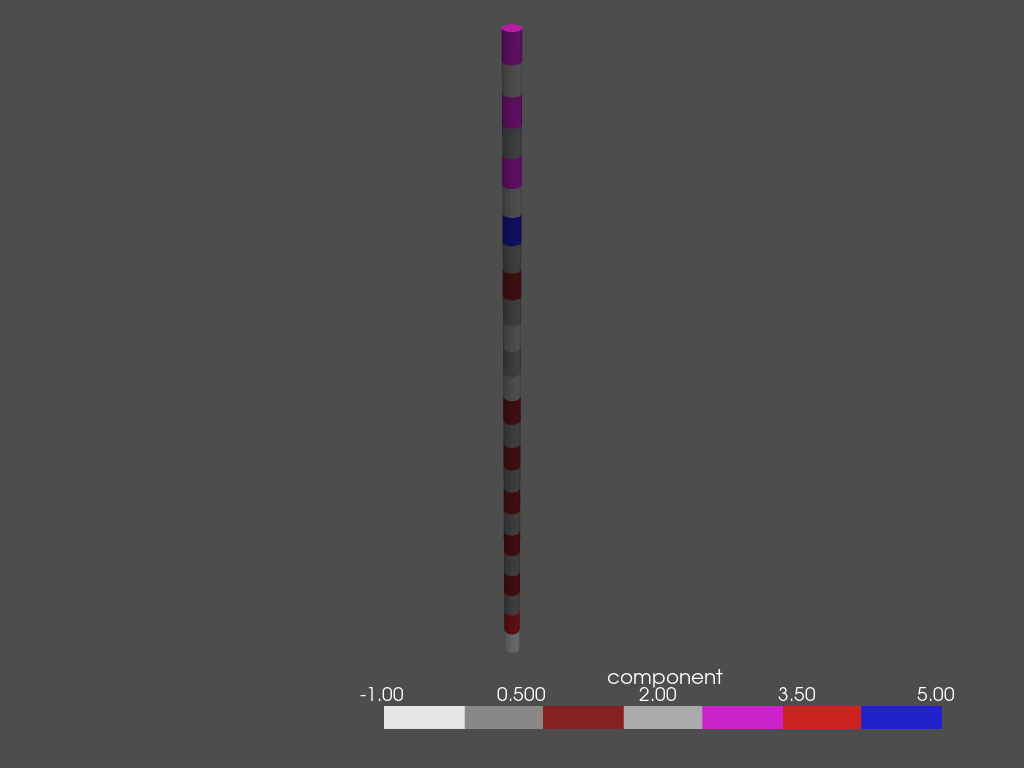

In [36]:
bh3d_2.plot3d()